<a href="https://colab.research.google.com/github/andrebelem/ASTOC/blob/main/SNIPPETS_1_Wavelets_%5BMaterial_de_Refer%C3%AAncia%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este é o material de referência para a análise de séries temporais onde vamos nos debruçar sobre as wavelets. Como referência, vou usar uma série longa de SST obtida no campo de Tupi (Bacia de Santos). Essa série foi gravada como "Parquet"(1) e está disponível no gdrive. Note que vou baixar o arquivo do gdrive conforme abaixo.

Vamos lá ?!

(1) O Parquet é especialmente útil para conjuntos de dados grandes e complexos, como aqueles encontrados em processamento de big data e análise de dados distribuídos. Ele oferece compressão eficiente, suporte para esquemas complexos e execução rápida de consultas, tornando-o uma escolha popular em ecossistemas de big data como Hadoop e Spark

In [1]:
import pandas as pd

df_tupi = df = pd.read_parquet('https://github.com/andrebelem/ASTOC/raw/main/dados_publicos/Dados_SST_tupi.parquet')

In [2]:
df_tupi

,sst_original,desazon,sazonal
time,,,
2008-04-02,26.699999,24.364090,2.335908
2008-04-03,26.685713,24.281941,2.403772
2008-04-04,26.871426,24.394134,2.477292
2008-04-05,26.871426,24.496562,2.374864
2008-04-06,26.864283,24.509692,2.354591
...,...,...,...
2019-01-12,26.632144,25.090004,1.542140
2019-01-13,26.649998,25.139361,1.510637
2019-01-14,26.796428,25.320950,1.475477


<Axes: xlabel='time', ylabel='SST [$\\degree$C]'>

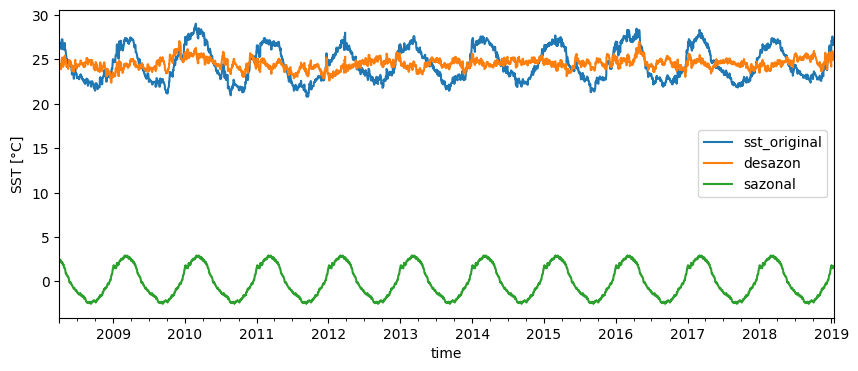

In [4]:
df_tupi.plot(label='ano',ylabel='SST [$\degree$C]',figsize=(10,4))

In [3]:
# vamos inovar um pouco e plotar com o plotly
import plotly.io as pio
pio.renderers.default = 'colab'

In [6]:
import plotly.graph_objects as go

# Criar o gráfico
fig = go.Figure(data=go.Scatter(x=df_tupi.index, y=df_tupi.desazon, mode='lines'))

# Exibir o gráfico
fig.show()

A série temporal tem uma característica essencialmente sazonal, mas ainda assim é possível enxergar alguns padrões em altas e baixas frequências "sobre" esse padrão sazonal. Então, este é um prato cheio para fazermos nossa análise wavelet, principalmente na série desazonalizada.

## Usando o pycwt

Existem "N" receitas de bolo na internet para fazer wavelets. Escolhemos uma que é baseada no aplicativo pycwt. Mas fiquem à vontade de procurar outras. Veja aqui https://pycwt.readthedocs.io/en/latest/

In [5]:
%%capture
# instala o wavelets
!pip install pycwt

# primeiro importa o que vamos usar
import pycwt as wavelet
from pycwt.helpers import find
import numpy as np

Antes de iniciar qualquer coisa, vamos descrever o dado.

In [41]:
# algumas definições
title = 'Sea Surface Temperature'
label = 'Tupi Field'
units = '$\degree$C'
t0 = 0
dt = 1/365.25  # em anos ! esse passo é muitooo importante, note que aqui eu estou assumindo a distribuição temporal contínua independente de anos bisextos

dat = np.array(df_tupi.sst_original) # simplesmente converte o meu Dataframe para um array usando o numpy
# artificialmente cria o vetor de tempo em decyears (pode ser que tenha outra maneira mais eficiente de fazer isso)
N = dat.size
t = np.arange(0, N) * dt + t0

As vezes é necessário diminuir a tendência e normalizar os dados de entrada por seu desvio padrão. Às vezes, a redução da distorção não é necessária e simplesmente remover o valor médio é suficiente. No entanto, se o seu conjunto de dados tiver uma tendência bem definida (como alguns conjuntos de dados de variáveis climáticas), é altamente recomendável realizar a redução da tendência. Aqui, ajustamos uma função polinomial de um grau e a subtraímos dos dados originais.

In [42]:
p = np.polyfit(t - t0, dat, 1) # usando o polyfit para normalizar o dado
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

Para saber se deu certo, vamos ver o resultado ... Não esperamos "grandes" mudanças aqui...

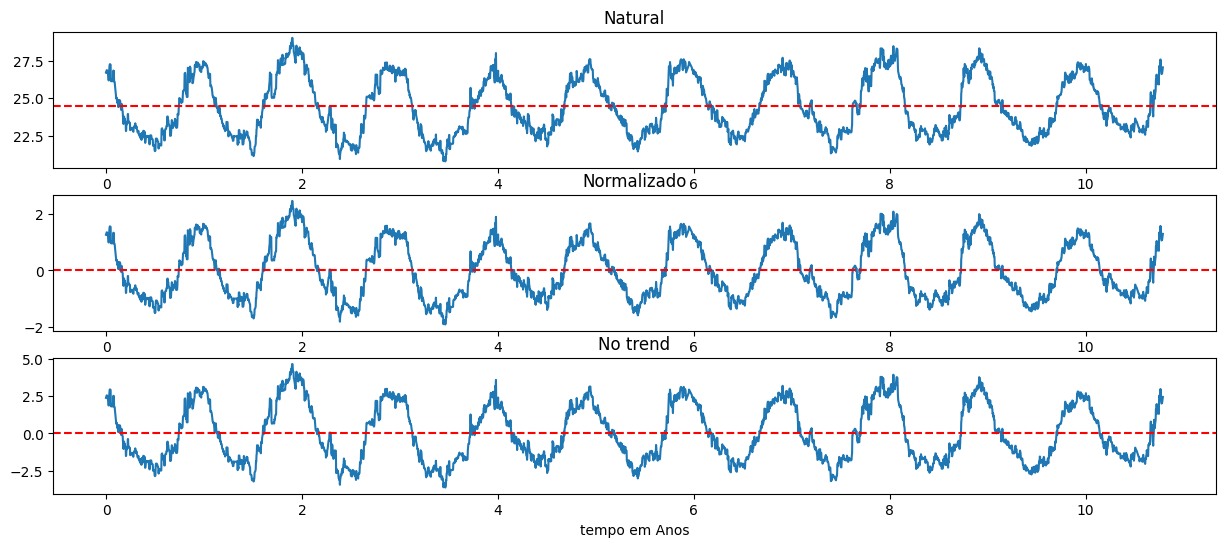

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize=(15,6))
ax[0].plot(t,dat)
ax[0].set_title('Natural')
ax[0].axhline(y=dat.mean(),linestyle='--',color='r')

ax[1].plot(t,dat_norm)
ax[1].set_title('Normalizado')
ax[1].axhline(y=dat_norm.mean(),linestyle='--',color='r')

ax[2].plot(t,dat_notrend)
ax[2].set_title('No trend')
ax[2].set_xlabel('tempo em Anos')
ax[2].axhline(y=dat_notrend.mean(),linestyle='--',color='r')
plt.show()

A próxima etapa é definir alguns parâmetros de nossa análise de wavelet. Selecionamos a wavelet mãe, neste caso a wavelet de Morlet com ω0 = 6.

In [44]:
mother = wavelet.Morlet(6)
s0 = 6 * dt  # Escala inicial, neste caso 4 * delta-t 1 anos = 4 anos
dj = 1 / 8  # 12 sub-oitavas por oitavas
J = 7 / dj  # 8 potências de dois com sub-oitavas dj
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelação para ruído vermelho !!!! muito importante !!!!!

As rotinas a seguir realizam a transformação wavelet e a transformada wavelet inversa usando os parâmetros definidos acima. Como normalizamos nossa série temporal de entrada, multiplicamos a transformação inversa pelo desvio padrão.

In [45]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J, mother)
#wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat, dt, dj, s0, J,mother) # note que vc pode desejar usar a série natural
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

Calculamos a wavelet normalizada e os espectros de potência de Fourier, bem como os períodos equivalentes de Fourier para cada escala de wavelet.

In [46]:
power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

In [47]:
# Opcionalmente, também poderíamos retificar o espectro de potência
# de acordo com as sugestões propostas por Liu et al. (2007)
# http://ocgweb.marine.usf.edu/~liu/Papers/Liu_etal_2007_JAOT_wavelet.pdf
#power /= scales[:, None]

Poderíamos parar neste ponto e traçar nossos resultados. No entanto, também estamos interessados no teste de significância de espectros de potência. A potência é significativa onde a relação potência / sig95> 1. Então veja que aqui, estamos "meio que assumindo" que nossa série é estacionária. Será ?

In [48]:
mysig = 0.95

signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=mysig, #<---- veja
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

Em seguida, calculamos o espectro wavelet global e determinamos seu nível de significância.

In [49]:
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges !!!
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=mysig, dof=dof, #<---- veja
                                        wavelet=mother)

Também calculamos a média da escala entre o min e o max do período (em anos) e seu nível de significância. Faço isso porque a série tem na verdade uns 10 anos. Isso só é necessário caso você queira descartar a "contaminação estatística" das pontas da sua série.


In [50]:
sel = find((period >= period.min()) & (period <= period.max()))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=mysig, #<---- veja
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

Finalmente, plotamos nossos resultados em quatro subparcelas diferentes contendo a (i) anomalia da série original e a transformada wavelet inversa; (ii) o espectro de potência da wavelet (iii) o espectro global da wavelet e de Fourier; e (iv) o espectro de wavelet de média de alcance. Em todos os subgráficos, os níveis de significância são incluídos como linhas pontilhadas ou como linhas de contorno preenchidas.

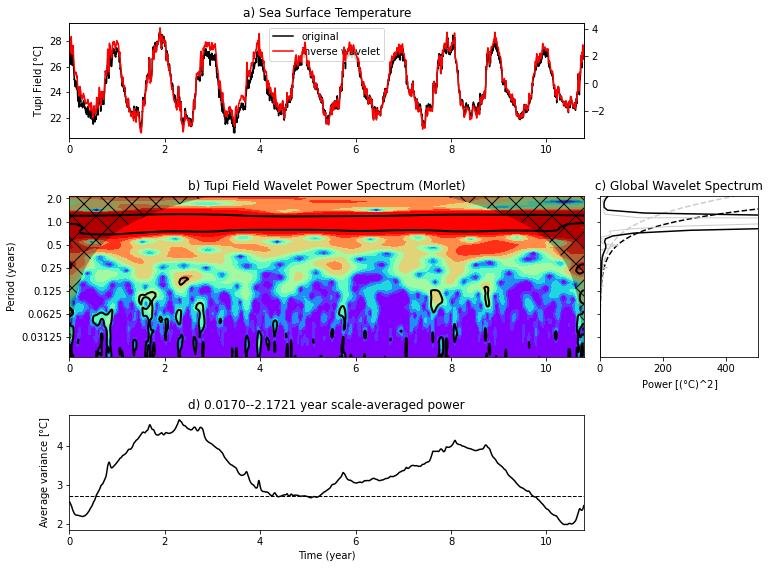

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = plt.figure(**figprops)

# Primeiro sub-gráfico, a anomalia da série temporal original e
# wavelet inversa.
ax = plt.axes([0.1, 0.75, 0.65, 0.2])
lns1 = ax.plot(t, dat, 'k', linewidth=1.5, label='original')
ax2 = ax.twinx()
lns2 = ax2.plot(t, iwave, '-', linewidth=1.5, color='r', label='inverse wavelet')
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Segundo sub-gráfico, o espectro de potência da wavelet normalizada e significância
# linhas de contorno niveladas e cone da área hachurada de influencia. Observe aquele período
# escala é logarítmica.
bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.rainbow)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)

# Terceiro sub-gráfico, wavelet global e espectros de potência de Fourier e teóricos
# espectro de ruído. Observe que a escala do período é logarítmica.
cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, np.log2(period), 'k--')
cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)

# Quarto sub-gráfico, o espectro de ondas médias da escala.
dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title(f'd) {period.min():.4f}--{period.max():.4f} year scale-averaged power')
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

plt.show()


O que vc enxerga ? quais as frequencias dominantes ? alterando os parâmetros de criação da Wavelet, o que você vê ?

**Estas perguntas DEVEM ser respondidas** <br>
Aqui o que vale é "estudo" sobre o método. Mas sei que é muita coisa para digerir em apenas 1 aula.

Artigos para ler:


*   http://ocgweb.marine.usf.edu/~liu/Papers/Liu_etal_2007_JAOT_wavelet.pdf
*   http://www.glaciology.net/Home/PDFs/Announcements/Application-of-the-cross-wavelet-transform-and-wavelet-coherence-to-geophysical-time-series-




